In [1]:
import numpy as np
import scipy as sc
import random as rand
from sklearn import preprocessing, linear_model
import matplotlib.pyplot as plt

from core.controllers import PDController
from core.dynamics import LinearSystemDynamics, ConfigurationDynamics

from koopman_core.controllers import OpenLoopController, MPCController,BilinearFBLinController, PerturbedController, LinearLiftedController
from koopman_core.dynamics import LinearLiftedDynamics, BilinearLiftedDynamics
from koopman_core.learning import Edmd, BilinearEdmd
from koopman_core.basis_functions import PolySineBasis, PlanarQuadBasis
from koopman_core.learning.utils import differentiate_vec
from koopman_core.systems import PlanarQuadrotorForceInput

class QuadrotorPdOutput(ConfigurationDynamics):
    def __init__(self, dynamics, xd, t_d, n, m):
        ConfigurationDynamics.__init__(self, dynamics, 1)
        self.xd = xd
        self.t_d = t_d
        self.xd_dot = differentiate_vec(self.xd, self.t_d)
        self.n = n
        self.m = m

    def proportional(self, x, t):
        q, q_dot = x[:int(n/2)], x[int(n/2):]
        return self.y(q) - self.y_d(t)

    def derivative(self, x, t):
        q, q_dot = x[:int(n/2)], x[int(n/2):]
        return self.dydq(q)@q_dot - self.y_d_dot(t)

    def y(self, q):
        return q

    def dydq(self, q):
        return np.eye(int(self.n/2))

    def d2ydq2(self, q):
        return np.zeros((int(self.n/2), int(self.n/2), int(self.n/2)))

    def y_d(self, t):
        return self.desired_state_(t)[:int(self.n/2)]

    def y_d_dot(self, t):
        return self.desired_state_(t)[int(self.n/2):]

    def y_d_ddot(self, t):
        return self.desired_state_dot_(t)[int(self.n/2):]

    def desired_state_(self, t):
        return [np.interp(t, self.t_d.flatten(),self.xd[:,ii].flatten()) for ii in range(self.xd.shape[1])]

    def desired_state_dot_(self, t):
        return [np.interp(t, self.t_d.flatten(),self.xd_dot[:,ii].flatten()) for ii in range(self.xd_dot.shape[1])]

class PlanarQuadrotorForceInputDiscrete(PlanarQuadrotorForceInput):
    def __init__(self, mass, inertia, prop_arm, g=9.81, dt=1e-2):
        PlanarQuadrotorForceInput.__init__(self, mass, inertia, prop_arm, g=g)
        self.dt=dt
        
    def eval_dot(self, x, u, t):
        return x + self.dt*self.drift(x, t) + self.dt*np.dot(self.act(x, t),u)

    def get_linearization(self, x0, x1, u0, t):
        m, J, b, g = self.params
        A_lin = np.eye(self.n) + self.dt*np.array([[0, 0, 0, 1, 0, 0],
                                                   [0, 0, 0, 0, 1, 0],
                                                   [0, 0, 0, 0, 0, 1],
                                                   [0, 0, -(1/m)*np.cos(x0[2])*u0[0] -(1/m)*np.cos(x0[2])*u0[1], 0, 0, 0],
                                                   [0, 0, -(1/m)*np.sin(x0[2])*u0[0] -(1/m)*np.sin(x0[2])*u0[1], 0, 0, 0],
                                                   [0, 0, 0, 0, 0, 0],])

        B_lin = self.dt*np.array([[0, 0],
                                  [0, 0],
                                  [0, 0],
                                  [-(1/m)*np.sin(x0[2]), -(1/m)*np.sin(x0[2])],
                                  [(1/m)*np.cos(x0[2]), (1/m)*np.cos(x0[2])],
                                  [-b/J, b/J]])

        if x1 is None:
            x1 = A_lin@x0 + B_lin@u0

        f_d = self.eval_dot(x0,u0,t)
        r_lin = f_d - x1

        return A_lin, B_lin, r_lin
    

## Planar Quadrotor Example

Consider a planar quadrotor with states $\mathbf{x} = [y \, z \, \theta \, \dot{y} \, \dot{z} \, \dot{\theta}]^T$ and continuous-time dynamics

\begin{equation}
    \begin{bmatrix} \ddot{y} \\ \ddot{z} \\ \ddot{\theta} \end{bmatrix}
    = \begin{bmatrix}
    0\\-g\\0
    \end{bmatrix} +
    \begin{bmatrix}
    -\frac{1}{m}\text{sin}\theta & -\frac{1}{m}\text{sin}\theta\\
    \frac{1}{m}\text{cos}\theta & \frac{1}{m}\text{cos}\theta\\
    -\frac{l_{arm}}{I_{xx}} & \frac{l_{arm}}{I_{xx}}
    \end{bmatrix}
    \begin{bmatrix}
    T_1 \\ T_2
    \end{bmatrix}
\end{equation}

where $y,z$ describe the position of the vehicle in a fixed reference frame, $\theta$ is the orientation of the vehicle,
$T_1, T_2$ are the thrust from each of the propellers, $g$ is the gravitational acceleration, $m$ is the vehicle mass,
$l_{arm}$ is the distance from the vehicle's center of mass to the center of the propeller, and $I_{xx}$ is the inertia
around the x-axis.

In [2]:
# Cart pole system parameters
mass = 2.
inertia = 1.
prop_arm = 0.2
gravity = 9.81
quadrotor = PlanarQuadrotorForceInput(mass, inertia, prop_arm, g=gravity)

# Linearized system specification:
n, m = 6, 2                                                         # Number of states, number of control inputs
A_nom = np.array([[0., 0., 0., 1., 0., 0.],                         # Linearization of the true system around the origin
                  [0., 0., 0., 0., 1., 0.],
                  [0., 0., 0., 0., 0., 1.],
                  [0., 0., -gravity, 0., 0., 0.],
                  [0., 0., 0., 0., 0., 0.],
                  [0., 0., 0., 0., 0., 0.]])
B_nom = np.array([[0., 0.],                                         # Linearization of the true system around the origin
                  [0., 0.],
                  [0., 0.],
                  [0., 0.],
                  [1./mass, 1./mass],
                  [-prop_arm/inertia, prop_arm/inertia]])

hover_thrust = mass*gravity/m

### Collect data for learning

To collect data, a nominal controller is designed with LQR on the dynamics's linearization around hover. However, any
controller can be used and the method does not require the knowledge of model's linearization. In addition, a
exploratory white noise is added to the controller to ensure that the data is sufficiently excited. Note that the system
is underactuated and that trajectory optimization is necessary to control the position of the vehicle. We use a
simplified trajectory generator based on a model predictive controller for the linearized dynamics. More careful design
of the desired trajectory may be necessary for more demanding applications and this is readily compatible with our method.



In [3]:
q_dc, r_dc = 1e2, 1                                                 # State and actuation penalty values, data collection
Q_dc = q_dc * np.identity(n)                                        # State penalty matrix, data collection
R_dc = r_dc*np.identity(m)                                          # Actuation penalty matrix, data collection
P_dc = sc.linalg.solve_continuous_are(A_nom, B_nom, Q_dc, R_dc)     # Algebraic Ricatti equation solution, data collection
K_dc = np.linalg.inv(R_dc)@B_nom.T@P_dc                             # LQR feedback gain matrix, data collection
K_dc_p = K_dc[:,:int(n/2)]                                          # Proportional control gains, data collection
K_dc_d = K_dc[:,int(n/2):]                                          # Derivative control gains, data collection
nominal_sys = LinearLiftedDynamics(A_nom, B_nom, np.eye(n), lambda x: x)

# Data collection parameters:
dt = 1.0e-2                                                         # Time step length
traj_length_dc = 2.                                                 # Trajectory length, data collection
n_pred_dc = int(traj_length_dc/dt)                                  # Number of time steps, data collection
t_eval = dt * np.arange(n_pred_dc + 1)                              # Simulation time points
n_traj_dc = 100   # TODO: set to 100                                # Number of trajectories to execute, data collection
noise_var = 2.                                                      # Exploration noise to perturb controller, data collection

xmax = np.array([2, 2, np.pi/3, 2.,2.,2.])                          # State constraints, trajectory generation
xmin = -xmax
umax = np.array([2*hover_thrust, 2*hover_thrust]) - hover_thrust    # Actuation constraint, trajectory generation
umin = np.array([0., 0.]) - hover_thrust
x0_max = np.array([xmax[0], xmax[1], xmax[2], 1., 1., 1.])          # Initial value limits
Q_trajgen = sc.sparse.diags([0,0,0,0,0,0])                          # State penalty matrix, trajectory generation
QN_trajgen = sc.sparse.diags([5e1,5e1,5e1,1e1,1e1,1e1])             # Final state penalty matrix, trajectory generation
R_trajgen = sc.sparse.eye(m)                                        # Actuation penalty matrix, trajectory generation
sub_sample_rate = 2                                                 # Rate to subsample data for training
model_fname = 'examples/planar_quad_models'                         # Path to save learned models
n_cols = 10                                                         # Number of columns in training data plot

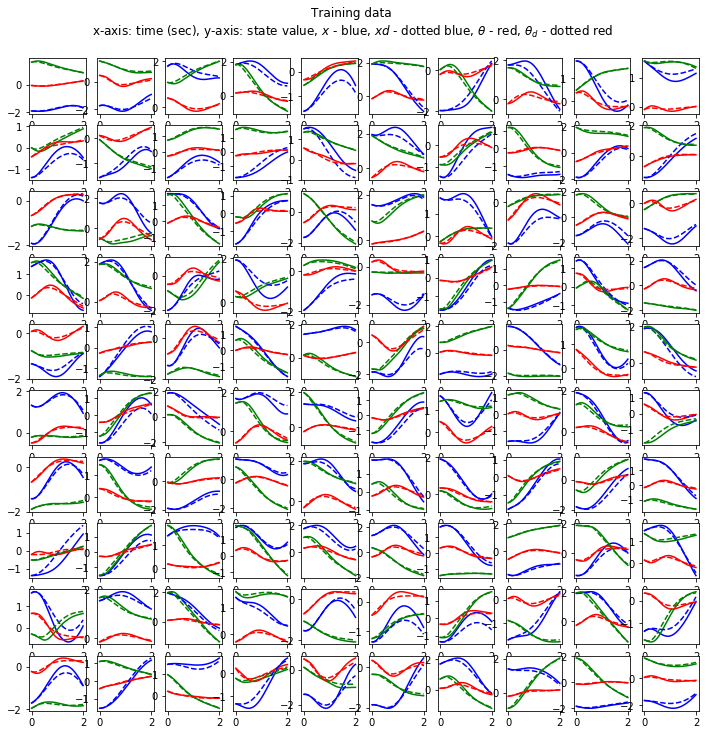

In [4]:
xd = np.empty((n_traj_dc, n_pred_dc + 1, n))
xs = np.empty((n_traj_dc, n_pred_dc + 1, n))
us = np.empty((n_traj_dc, n_pred_dc, m))

plt.figure(figsize=(12, 12 * n_traj_dc / (n_cols ** 2)))
for ii in range(n_traj_dc):
    x0 = np.asarray([rand.uniform(l, u) for l, u in zip(-x0_max, x0_max)])
    set_pt_dc = np.asarray([rand.uniform(l, u) for l, u in zip(-x0_max, x0_max)])
    mpc_trajgen = MPCController(nominal_sys, n_pred_dc, dt, umin, umax, xmin, xmax, QN_trajgen, R_trajgen,
                                QN_trajgen, set_pt_dc)
    mpc_trajgen.eval(x0, 0)
    xd[ii, :, :] = mpc_trajgen.parse_result().T
    while abs(x0[0]) < 1.25 or np.any(np.isnan(xd[ii, :, :])):
        x0 = np.asarray([rand.uniform(l, u) for l, u in zip(-x0_max, x0_max)])
        set_pt_dc = np.asarray([rand.uniform(l, u) for l, u in zip(-x0_max, x0_max)])
        mpc_trajgen = MPCController(nominal_sys, n_pred_dc, dt, umin, umax, xmin, xmax, QN_trajgen, R_trajgen,
                                    QN_trajgen, set_pt_dc)
        mpc_trajgen.eval(x0, 0)
        xd[ii, :, :] = mpc_trajgen.parse_result().T

    output = QuadrotorPdOutput(quadrotor, xd[ii, :, :], t_eval, n, m)
    pd_controller = PDController(output, K_dc_p, K_dc_d)
    perturbed_pd_controller = PerturbedController(quadrotor, pd_controller, noise_var, const_offset=hover_thrust)
    xs[ii, :, :], us[ii, :, :] = quadrotor.simulate(x0, perturbed_pd_controller, t_eval)

    plt.subplot(int(np.ceil(n_traj_dc / n_cols)), n_cols, ii + 1)
    plt.plot(t_eval, xs[ii, :, 0], 'b', label='$y$')
    plt.plot(t_eval, xs[ii, :, 1], 'g', label='$z$')
    plt.plot(t_eval, xs[ii, :, 2], 'r', label='$\\theta$')
    plt.plot(t_eval, xd[ii, :, 0], '--b', label='$y_d$')
    plt.plot(t_eval, xd[ii, :, 1], '--g', label='$z_d$')
    plt.plot(t_eval, xd[ii, :, 2], '--r', label='$\\theta_d$')

plt.suptitle(
    'Training data \nx-axis: time (sec), y-axis: state value, $x$ - blue, $xd$ - dotted blue, $\\theta$ - red, $\\theta_d$ - dotted red',
    y=0.94)
plt.show()

### Learn a lifted bilinear model with bilinear extended mode decomposition (bEDMD)

Finally, we use the method developed in the paper to learn a lifted bilinear model of the dynamics, dubbed bilinear
extended mode decomposition (bEDMD). I.e. we first lift and then use linear regression with LASSO regularization to learn an approximate
lifted linear model with model structure

\begin{equation}
    \mathbf{\dot{z}}=F\mathbf{z}+\sum_{i=1}^m G_i\mathbf{z}\mathbf{u}_i, \qquad \mathbf{z} = \boldsymbol{\phi(x)}
\end{equation}

In [5]:
def circular_obstacle(x, c, r):
    '''
    Circular obstacle avoidance constraint of the form h(x) >= 0.
    h(x) = (x-c)'(x-c) - r^2 
    '''
    
    h = (x[:2] - c).T@(x[:2] - c) - r**2
    D = np.hstack([2*(x[:2] - c), np.zeros(4)])
    
    return D, h

r = 0.3
safe_marg = 0.025
c = np.array([[0.5, 0.8]])
obstacle = lambda x: circular_obstacle(x, c.squeeze(), r)

In [6]:
#Bilinear EDMD parameters:                                          # Regularization strength (LASSO) bEDMD
alpha_bedmd = 4e-4
tune_mdl_bedmd = True

In [7]:
#basis = PlanarQuadBasis(n, poly_deg=3, circ_obs_c=c, circ_obs_r=r)
#basis = PlanarQuadBasis(n, poly_deg=3)
basis = PolySineBasis(n, poly_deg=2)
basis.construct_basis()
planar_quad_features = preprocessing.FunctionTransformer(basis.basis)
planar_quad_features.fit(np.zeros((1,n)))
n_lift_bedmd = planar_quad_features.transform((np.zeros((1,n)))).shape[1]
C_bedmd = np.zeros((n,n_lift_bedmd))
C_bedmd[:,1:n+1] = np.eye(n)
C_h_bedmd = np.zeros((1,n_lift_bedmd))
C_h_bedmd[:,-1] = 1

basis_bedmd = lambda x: planar_quad_features.transform(x)
optimizer_bedmd = linear_model.MultiTaskLasso(alpha=alpha_bedmd, fit_intercept=False, selection='random') #, max_iter=5000
cv_bedmd = linear_model.MultiTaskLassoCV(fit_intercept=False, n_jobs=-1, cv=3, selection='random')
standardizer_bedmd = preprocessing.StandardScaler(with_mean=False)

model_bedmd = BilinearEdmd(n, m, basis_bedmd, n_lift_bedmd, n_traj_dc, optimizer_bedmd, cv=cv_bedmd, standardizer=standardizer_bedmd, C=C_bedmd, continuous_mdl=False, dt=dt)
X_bedmd, y_bedmd = model_bedmd.process(xs, us-hover_thrust, np.tile(t_eval,(n_traj_dc,1)), downsample_rate=sub_sample_rate)
model_bedmd.fit(X_bedmd, y_bedmd, cv=tune_mdl_bedmd, override_kinematics=True)
sys_bedmd = BilinearLiftedDynamics(model_bedmd.n_lift, m, model_bedmd.A, model_bedmd.B, model_bedmd.C, model_bedmd.basis, continuous_mdl=False, dt=dt, C_h=C_h_bedmd)
#sys_bedmd = BilinearLiftedDynamics(model_bedmd.n_lift, m, model_bedmd.A, model_bedmd.B, model_bedmd.C, model_bedmd.basis, continuous_mdl=False, dt=dt)
if tune_mdl_bedmd:
    print('$\\alpha$ bilinear EDMD: ', model_bedmd.cv.alpha_)

print(n_lift_bedmd)

$\alpha$ bilinear EDMD:  0.0003874009202835576
84


/Users/carlaxelfolkestad/.conda/envs/keedmd/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:1790: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.37546336775254296, tolerance: 0.039279632321226665
  check_random_state(self.random_state), random)


#### Save learned models

In [8]:
import dill

model_fname = 'examples/planar_quad_collision_model'
model_dict = {'sys_bedmd': sys_bedmd,'model_bedmd': model_bedmd}
with open(model_fname, 'wb') as handle:
        dill.dump(model_dict, handle)


### Evaluate open loop prediction performance

We first evaluate the open loop prediction performance of the proposed method.
This is done by generating a new data set in the same way as the training set, predicting the evolution of the system
with the control sequence of each trajectory executed in the data set with each of the models, and finally comparing
the mean and standard deviation of the error between the true and predicted evolution over the trajectories. The
experimental results support what is to be expected from the theory as the error in the $y$ and $z$ terms are
significantly lower for the bEDMD method than both DMD and EDMD. The reason for this
improvement is that the bEDMD method can capture the nonlinearities present in the actuation matrix of the
$(y,z)$-dynamics.

In [9]:
# Prediction performance evaluation parameters:
folder_plots = 'examples/figures/'                                  # Path to save plots
n_traj_ol = 100 #TODO: Set to 100                                                      # Number of trajectories to execute, open loop

In [10]:
from tabulate import tabulate

xs_ol = np.empty((n_traj_ol, t_eval.shape[0], n))
xs_bedmd_ol = np.empty((n_traj_ol, t_eval.shape[0]-1, n))
us_test = np.empty((n_traj_ol, t_eval.shape[0]-1, m))

for ii in range(n_traj_ol):
    x0 = np.asarray([rand.uniform(l, u) for l, u in zip(-x0_max, x0_max)])
    set_pt_dc = np.asarray([rand.uniform(l, u) for l, u in zip(-x0_max, x0_max)])
    mpc_trajgen = MPCController(nominal_sys, n_pred_dc, dt, umin, umax, xmin, xmax, QN_trajgen, R_trajgen,
                                QN_trajgen, set_pt_dc)
    mpc_trajgen.eval(x0, 0)
    xd = mpc_trajgen.parse_result().T

    while xd[0,0] is None:
        x0 = np.asarray([rand.uniform(l, u) for l, u in zip(-x0_max, x0_max)])
        set_pt_dc = np.asarray([rand.uniform(l, u) for l, u in zip(-x0_max, x0_max)])
        mpc_trajgen = MPCController(nominal_sys, n_pred_dc, dt, umin, umax, xmin, xmax, QN_trajgen, R_trajgen,
                                    QN_trajgen, set_pt_dc)
        mpc_trajgen.eval(x0, 0)
        xd = mpc_trajgen.parse_result().T

    output = QuadrotorPdOutput(quadrotor, xd, t_eval, n, m)
    pd_controller = PDController(output, K_dc_p, K_dc_d)
    perturbed_pd_controller = PerturbedController(quadrotor, pd_controller, noise_var, const_offset=hover_thrust)

    xs_ol[ii,:,:], us_test[ii,:,:] = quadrotor.simulate(x0, perturbed_pd_controller, t_eval)
    ol_controller_nom = OpenLoopController(sys_bedmd, us_test[ii,:,:]-hover_thrust, t_eval[:-1])

    z_0_bedmd = sys_bedmd.basis(np.atleast_2d(x0)).squeeze()
    zs_bedmd_tmp, _ = sys_bedmd.simulate(z_0_bedmd, ol_controller_nom, t_eval[:-1])
    xs_bedmd_ol[ii,:,:] = np.dot(model_bedmd.C, zs_bedmd_tmp.T).T

error_bedmd = xs_ol[:,:-1,:] - xs_bedmd_ol
error_bedmd_mean = np.mean(error_bedmd, axis=0).T
error_bedmd_std = np.std(error_bedmd, axis=0).T
mse_bedmd = np.mean(np.mean(np.mean(np.square(error_bedmd))))

print('\nOpen loop performance statistics:\n')
print(tabulate([['bEDMD', "{:.3f}".format(mse_bedmd)]], 
               headers=['Learned model', 'MSE']))


Open loop performance statistics:

Learned model      MSE
---------------  -----
bEDMD            0.114


In [11]:
err_obs = []
for ii in range(n_traj_ol):
    x_ol = xs_ol[ii,:-1,:]
    x_bedmd_ol = xs_bedmd_ol[ii,:,:]
    err_obs.append(sys_bedmd.basis(x_ol)[:,-1] - sys_bedmd.basis(x_bedmd_ol)[:,-1])
    
err_obs = np.array(err_obs)
err_obs_mean = np.mean(err_obs, axis=0)
err_obs_std = np.std(err_obs, axis=0)

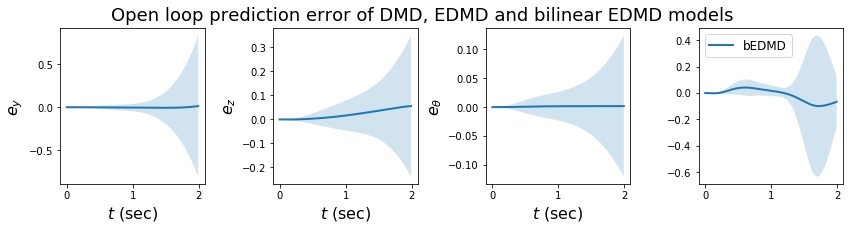

In [12]:
import matplotlib.pyplot as plt
import matplotlib

figwidth = 12
lw = 2
fs = 16
y_lim_gain = 1.2

#Plot open loop results:
ylabels = ['$e_{y}$', '$e_z$', '$e_{\\theta}$', '$e_{obs}$']
inds = [0, 1, 2]
plt.figure(figsize=(figwidth,3))
for ii in range(3):
    plt.subplot(1,4,ii+1)
    plt.plot(t_eval[:-1], error_bedmd_mean[inds[ii], :], linewidth=lw, label='bEDMD')
    plt.fill_between(t_eval[:-1], error_bedmd_mean[inds[ii], :] - error_bedmd_std[inds[ii], :],error_bedmd_mean[inds[ii], :] + error_bedmd_std[inds[ii], :], alpha=0.2)
#    ylim = max(max(np.abs(error_bedmd_mean[inds[ii], :] - error_bedmd_std[inds[ii], :])), max(np.abs(error_bedmd_mean[inds[ii], :] + error_bedmd_std[inds[ii], :])))
#    plt.ylim([-ylim * y_lim_gain, ylim * y_lim_gain])
    plt.xlabel('$t$ (sec)', fontsize=fs)
    plt.ylabel(ylabels[ii], fontsize=fs)
    
plt.subplot(1,4,4)
plt.plot(t_eval[:-1], err_obs_mean, linewidth=lw, label='bEDMD')
plt.fill_between(t_eval[:-1], err_obs_mean - err_obs_std,err_obs_mean + err_obs_std, alpha=0.2)

plt.legend(loc='upper left', fontsize=fs-4)
suptitle = plt.suptitle('Open loop prediction error of DMD, EDMD and bilinear EDMD models', y=1.05, fontsize=18)
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
plt.tight_layout()
plt.savefig(folder_plots + 'planar_quad_prediction.pdf', format='pdf', dpi=2400, bbox_extra_artists=(suptitle,), bbox_inches="tight")
plt.show()

# Design trajectories based on learned models

We now study the closed loop performance of the control design. 

In [13]:
#Closed loop performance evaluation parameters:
t_eval = dt * np.arange(201)                                     # Simulation time points, closed loop
Q_mpc = sc.sparse.diags([0,0,0,0,0,0])                       # State penalty matrix, trajectory generation
QN_mpc = sc.sparse.diags([1e5,1e5,1e5,1e4,1e4,1e4])          # Final state penalty matrix, trajectory generation
R_mpc = sc.sparse.eye(m)                                     # Actuation penalty matrix, trajectory generation
traj_length=200
ctrl_offset = np.array([hover_thrust, hover_thrust])

# Design trajectory:
x0_cl = np.array([0., 0., 0., 0., 0., 0.])                         # Initial value, closed loop trajectory
set_pt_cl = np.array([1., 1., 0., 0., 0., 0.])                      # Desired final value, closed loop trajectory
term_constraint=False

# Define initial solution for SQP algorithm:
mid_pt_cl = np.array([0.1,1.2,0.,0.,0.,0.])
x_init = np.vstack((np.linspace(x0_cl, mid_pt_cl, int(traj_length/2)), np.linspace(mid_pt_cl, set_pt_cl, int(traj_length/2)+1)))
u_init = np.zeros((m,traj_length)).T

#### Design controllers for learned bEDMD models

In [14]:
from koopman_core.controllers import MPCController, NonlinearMPCController, BilinearMPCController

# Define bEDMD-based controller:
controller_bedmd = BilinearMPCController(sys_bedmd, traj_length, dt, umin, umax, xmin, xmax, Q_mpc, R_mpc, QN_mpc, set_pt_cl, terminal_constraint=term_constraint, const_offset=ctrl_offset)
z0_cl = sys_bedmd.basis(x0_cl.reshape((1,-1))).squeeze()
z_init = sys_bedmd.basis(x_init)
controller_bedmd.construct_controller(z_init, u_init)

#### Design controller using full knowledge of nonlinear controller

In [15]:
quadrotor_d = PlanarQuadrotorForceInputDiscrete(mass, inertia, prop_arm, g=gravity, dt=dt)
controller_nmpc = NonlinearMPCController(quadrotor_d, traj_length, dt, umin+hover_thrust, umax+hover_thrust, xmin, xmax, Q_mpc, R_mpc, QN_mpc, set_pt_cl, terminal_constraint=term_constraint, obstacle=obstacle)
controller_nmpc.construct_controller(x_init, u_init)

#### Design trajectories with the contructed MPCs

In [16]:
max_iter = 50

controller_bedmd.solve_to_convergence(z0_cl, 0., z_init, u_init, max_iter=max_iter)
xr_bedmd = sys_bedmd.C@controller_bedmd.get_state_prediction().T
ur_bedmd = controller_bedmd.get_control_prediction().T + ctrl_offset.reshape(-1,1)

controller_nmpc.solve_to_convergence(x0_cl, 0., x_init, u_init + ctrl_offset.reshape(1,-1), max_iter=max_iter)
xr_nmpc = controller_nmpc.get_state_prediction().T
ur_nmpc = controller_nmpc.get_control_prediction().T

#### Simulate designed trajectories open loop

In [17]:
ol_controller_bedmd = OpenLoopController(quadrotor, ur_bedmd.T, t_eval[:-1])
xs_bedmd, us_bedmd = quadrotor.simulate(x0_cl, ol_controller_bedmd, t_eval)
xs_bedmd, us_bedmd = xs_bedmd.T, us_bedmd.T

ol_controller_nmpc = OpenLoopController(quadrotor, ur_nmpc.T, t_eval[:-1])
xs_nmpc, us_nmpc = quadrotor.simulate(x0_cl, ol_controller_nmpc, t_eval)
xs_nmpc, us_nmpc = xs_nmpc.T, us_nmpc.T

##### Compare performance

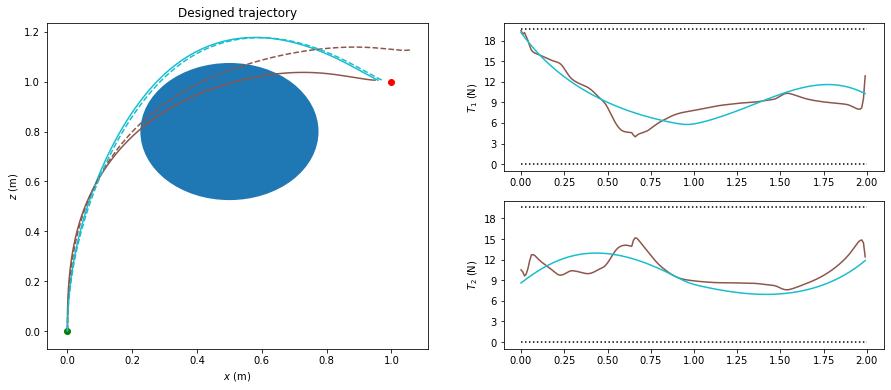

Solution statistics:

                       Normalized cost,       Normalized cost,      # of SQP         Mean comp. time    Total comp.
                    designed trajectory    realized trajectory    iterations    per iteration (secs)    time (secs)
----------------  ---------------------  ---------------------  ------------  ----------------------  -------------
bEDMD MPC                        1.1368                 1.1524            50                  8.8485      442.425
NMPC (benchmark)                 1                      0.9976            50                  0.074         3.69812


In [18]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

labels = ['$x$ (m)', '$z$ (m)', '$\\theta$ (rad)', '$\\dot{x}$ (m/s)','$\\dot{z}$ (m/s)', '$\\dot{\\theta}$', '$T_1$ (N)','$T_2$ (N)']
colors = ['tab:blue', 'tab:orange', 'tab:brown', 'tab:cyan']

plt.figure(figsize=(15,6))
#plt.suptitle('Trajectory designed with model predictive controllers\nsolid lines - designed trajectory | dashed lines - open loop simulated trajectory | black dotted lines - state/actuation bounds')
ax = plt.subplot(1,2,1)
plt.plot(xr_bedmd[0,:], xr_bedmd[1,:], color=colors[2], label='bEDMD NPMC')
plt.plot(xr_nmpc[0,:], xr_nmpc[1,:], color=colors[3], label='NPMC')
plt.plot(xs_bedmd[0,:], xs_bedmd[1,:],'--', color=colors[2])
plt.plot(xs_nmpc[0,:], xs_nmpc[1,:],'--', color=colors[3])

plt.scatter(x0_cl[0], x0_cl[1], color='g')
plt.scatter(set_pt_cl[0], set_pt_cl[1], color='r')
ax.add_artist(plt.Circle(c.squeeze(), r-safe_marg))

plt.title('Designed trajectory')
plt.xlabel(labels[0])
plt.ylabel(labels[1])

subplot_inds = [2, 4]
for ii in range(m):
    ax = plt.subplot(2,2,subplot_inds[ii])
    plt.plot(t_eval[:-1], ur_bedmd[ii, :], color=colors[2], label='bEDMD MPC')
    plt.plot(t_eval[:-1],ur_nmpc[ii,:], color=colors[3], label='Nonlinear MPC')
    plt.plot([0, 2.], [umax[ii]+hover_thrust, umax[ii]+hover_thrust], ':k')
    plt.plot([0, 2.], [umin[ii]+hover_thrust, umin[ii]+hover_thrust], ':k')
    plt.ylabel(labels[6+ii])
    ax.yaxis.set_major_locator(MaxNLocator(integer=True))
        
    if subplot_inds[ii] == 7 or subplot_inds[ii] == 8 or subplot_inds[ii] == 6:
        plt.xlabel('Time (sec)')

#matplotlib.rcParams['pdf.fonttype'] = 42
#matplotlib.rcParams['ps.fonttype'] = 42
#plt.tight_layout()
#plt.savefig(folder_plots + 'planar_quad_closedloop.pdf', format='pdf', dpi=2400, bbox_extra_artists=(suptitle,),
#            bbox_inches="tight")
plt.show()

cost_ref_bedmd = (xr_bedmd[:,-1]-set_pt_cl).T@QN_mpc@(xr_bedmd[:,-1]-set_pt_cl) + np.sum(np.diag(ur_bedmd.T@R_mpc@ur_bedmd))
cost_ref_nmpc = (xr_nmpc[:,-1]-set_pt_cl).T@QN_mpc@(xr_nmpc[:,-1]-set_pt_cl) + np.sum(np.diag(ur_nmpc.T@R_mpc@ur_nmpc))

cost_ol_bedmd = (xs_bedmd[:,-1]-set_pt_cl).T@QN_mpc@(xs_bedmd[:,-1]-set_pt_cl) + np.sum(np.diag(us_bedmd.T@R_mpc@us_bedmd))
cost_ol_nmpc = (xs_nmpc[:,-1]-set_pt_cl).T@QN_mpc@(xs_nmpc[:,-1]-set_pt_cl) + np.sum(np.diag(us_nmpc.T@R_mpc@us_nmpc))

print('Solution statistics:\n')
print(tabulate([['bEDMD MPC', "{:.4f}".format(cost_ref_bedmd/cost_ref_nmpc), "{:.4f}".format(cost_ol_bedmd/cost_ol_nmpc), len(controller_bedmd.x_iter), "{:.4f}".format(np.mean(controller_bedmd.comp_time)), sum(controller_bedmd.comp_time)],
                ['NMPC (benchmark)', 1, "{:.4f}".format(cost_ol_nmpc/cost_ref_nmpc), len(controller_nmpc.x_iter), "{:.4f}".format(np.mean(controller_nmpc.comp_time)), sum(controller_nmpc.comp_time)]], 
               headers=['Normalized cost,\ndesigned trajectory', 'Normalized cost,\nrealized trajectory', '# of SQP\niterations','Mean comp. time\nper iteration (secs)', 'Total comp.\ntime (secs)']))

#### Study evolution of the solution after each iteration of the SQP-algorithm

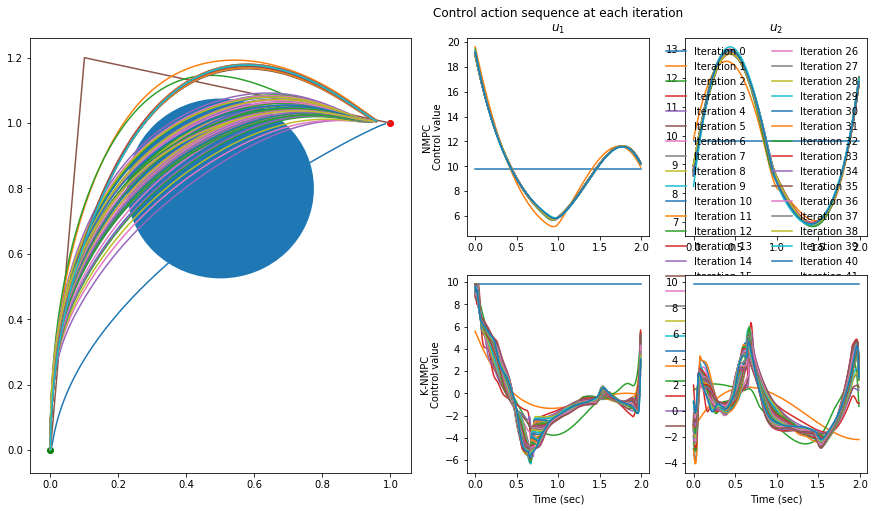

Solution statistics

                        Number of SQP    Mean comp. time per    Std comp. time per    Total comp.
                           iterations       iteration (secs)      iteration (secs)    time (secs)
--------------------  ---------------  ---------------------  --------------------  -------------
Nonlinear MPC                      50              0.0739625             0.0115225        3.69812
Koopman bilinear MPC               50              8.8485                3.01577        442.425


In [19]:
n_iter = min(len(controller_nmpc.x_iter),len(controller_bedmd.x_iter))

# Calculate cost after each iteration:
iter_cost_bedmd, iter_cost_nmpc = [], []

ol_controller_init = OpenLoopController(quadrotor, u_init, t_eval[:-1])
xs_init, _ = quadrotor.simulate(x0_cl, ol_controller_init, t_eval)
xs_init, us_init = xs_init.T, u_init.T
init_cost = (xs_init[:,-1]-set_pt_cl).T@QN_mpc@(xs_init[:,-1]-set_pt_cl) + np.sum(np.diag(us_init.T@R_mpc@us_init))
iter_cost_bedmd = [init_cost]
iter_cost_nmpc = [init_cost]

for ii in range(len(controller_bedmd.x_iter)):
    ur_bedmd_iter = controller_bedmd.u_iter[ii].T+hover_thrust
    ol_controller_bedmd_iter = OpenLoopController(quadrotor, ur_bedmd_iter, t_eval[:-1])
    xs_bedmd_iter, _ = quadrotor.simulate(x0_cl, ol_controller_bedmd_iter, t_eval)
    xs_bedmd_iter, us_bedmd_iter = xs_bedmd_iter.T, ur_bedmd_iter.T
    iter_cost_bedmd.append((xs_bedmd_iter[:,-1]-set_pt_cl).T@QN_mpc@(xs_bedmd_iter[:,-1]-set_pt_cl) + np.sum(np.diag(us_bedmd_iter.T@R_mpc@us_bedmd_iter)))
    
for ii in range(len(controller_nmpc.x_iter)):
    ur_nmpc_iter = controller_nmpc.u_iter[ii].T
    ol_controller_nmpc_iter = OpenLoopController(quadrotor, ur_nmpc_iter, t_eval[:-1])
    xs_nmpc_iter, _ = quadrotor.simulate(x0_cl, ol_controller_nmpc_iter, t_eval)
    xs_nmpc_iter, us_nmpc_iter = xs_nmpc_iter.T, ur_nmpc_iter.T
    iter_cost_nmpc.append((xs_nmpc_iter[:,-1]-set_pt_cl).T@QN_mpc@(xs_nmpc_iter[:,-1]-set_pt_cl) + np.sum(np.diag(us_nmpc_iter.T@R_mpc@us_nmpc_iter)))

plt.figure(figsize=(15,8))
#plt.suptitle('Control solution after each iteration of the SQP-algorithm for NMPC and K-NMPC')
ax0 = plt.subplot(1,2,1)
ax0.plot(x_init[:,0], x_init[:,1], color=colors[2], label='bEDMD NPMC')
#ax0.plot(x_init[0,:], x_init[1,:], color=colors[3], label='NPMC')
ax0.scatter(x0_cl[0], x0_cl[1], color='g')
ax0.scatter(set_pt_cl[0], set_pt_cl[1], color='r')
ax0.add_artist(plt.Circle(c.squeeze(), r-safe_marg))

ax1 = plt.subplot(2,4,3)
ax1.plot(t_eval[:-1],u_init[:, 0]+hover_thrust)
ax2 = plt.subplot(2,4,4)
ax2.plot(t_eval[:-1],u_init[:, 1]+hover_thrust, label='Iteration 0')
ax3 = plt.subplot(2,4,7)
ax3.plot(t_eval[:-1],u_init[:, 0]+hover_thrust)
ax4 = plt.subplot(2,4,8)
ax4.plot(t_eval[:-1],u_init[:, 0]+hover_thrust)

for it in range(n_iter):
    ax0.plot((sys_bedmd.C@controller_bedmd.x_iter[it])[0,:], (sys_bedmd.C@controller_bedmd.x_iter[it])[1,:])
    ax0.plot(controller_nmpc.x_iter[it][0,:], controller_nmpc.x_iter[it][1,:])
    ax1.plot(t_eval[:-1],controller_nmpc.u_iter[it][0,:])
    ax2.plot(t_eval[:-1],controller_nmpc.u_iter[it][1,:], label='Iteration '+str(it+1))
    ax3.plot(t_eval[:-1],controller_bedmd.u_iter[it][0,:])
    ax4.plot(t_eval[:-1],controller_bedmd.u_iter[it][1,:])
    
#ax5 = plt.subplot(1,3,3)
#ax5.plot(np.arange(n_iter), iter_cost_nmpc[:n_iter]/iter_cost_nmpc[-1], 'tab:cyan', label='NMPC')
#ax5.plot(np.arange(n_iter), iter_cost_bedmd[:n_iter]/iter_cost_nmpc[-1], 'k', label='K-NMPC')

ax1.set_title('Control action sequence at each iteration\n$u_1$')
ax1.set_ylabel('NMPC\nControl value')
ax2.set_title('$u_2$')
ax2.legend(ncol=2, loc='upper right', frameon=False)
ax3.set_ylabel('K-NMPC\nControl value')
ax3.set_xlabel('Time (sec)')
ax4.set_xlabel('Time (sec)')
#ax5.set_title('Realized cost after each iteration\n')
#ax5.set_xlabel('Iteration')
#ax5.set_ylabel('Cost (normalized)')
#ax5.legend(loc='upper right', frameon=False)

plt.show()

print('Solution statistics\n')
print(tabulate([['Nonlinear MPC', len(controller_nmpc.x_iter), np.mean(controller_nmpc.comp_time), np.std(controller_nmpc.comp_time), sum(controller_nmpc.comp_time)],
                ['Koopman bilinear MPC', len(controller_bedmd.x_iter), np.mean(controller_bedmd.comp_time), np.std(controller_bedmd.comp_time), sum(controller_bedmd.comp_time)]], 
               headers=['Number of SQP\niterations','Mean comp. time per\niteration (secs)', 'Std comp. time per\niteration (secs)', 'Total comp.\ntime (secs)']))

# Evaluate performance of controllers for closed-loop control

#### Design finite horizon controllers

In [20]:
from koopman_core.controllers import PerturbedController

Q_mpc_cl = 1e4*np.diag([1, 1, 1, 2e-1, 2e-1, 2e-1])
QN_mpc_cl = Q_mpc_cl
R_mpc_cl = np.eye(m)
traj_duration = 1
N_cl = int(traj_duration/dt)
t_eval=np.arange(250)*dt

controller_bedmd_cl = BilinearMPCController(sys_bedmd, N_cl, dt, umin, umax, xmin, xmax, Q_mpc_cl, R_mpc_cl, QN_mpc_cl, set_pt_cl, terminal_constraint=term_constraint)
controller_bedmd_cl.construct_controller(controller_bedmd.cur_z[:N_cl+1,:], controller_bedmd.cur_u[:N_cl,:])
controller_bedmd_cl.solve_to_convergence(z0_cl, 0., controller_bedmd.cur_z[:N_cl+1,:], controller_bedmd.cur_u[:N_cl,:], max_iter=max_iter)
controller_bedmd_cl = PerturbedController(sys_bedmd,controller_bedmd_cl,0.,const_offset=hover_thrust, umin=umin, umax=umax)

controller_nmpc_cl = NonlinearMPCController(quadrotor_d, N_cl, dt, umin+hover_thrust, umax+hover_thrust, xmin, xmax, Q_mpc_cl, R_mpc_cl, QN_mpc_cl, set_pt_cl, terminal_constraint=term_constraint, obstacle=obstacle)
controller_nmpc_cl.construct_controller(controller_nmpc.cur_z[:N_cl+1,:], controller_nmpc.cur_u[:N_cl,:])
controller_nmpc_cl.solve_to_convergence(x0_cl, 0., controller_nmpc.cur_z[:N_cl+1,:], controller_nmpc.cur_u[:N_cl,:], max_iter=max_iter)

#### Simulate designed trajectories closed-loop

In [21]:
controller_bedmd_cl.comp_time = []
xs_bedmd_cl, us_bedmd_cl = quadrotor.simulate(x0_cl, controller_bedmd_cl, t_eval)
xs_bedmd_cl, us_bedmd_cl = xs_bedmd_cl.T, us_bedmd_cl.T

controller_nmpc_cl.comp_time = []
xs_nmpc_cl, us_nmpc_cl = quadrotor.simulate(x0_cl, controller_nmpc_cl, t_eval)
xs_nmpc_cl, us_nmpc_cl = xs_nmpc_cl.T, us_nmpc_cl.T

#### Plot/analyze the results

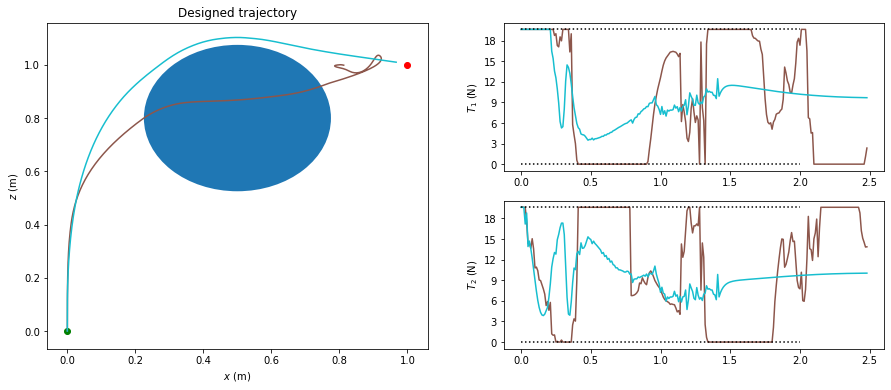

Solution statistics:

Normalized cost,            Normalized cost,         Mean comp. time          std comp. time
designed trajectory      realized trajectory    per iteration (secs)    per iteration (secs)
---------------------  ---------------------  ----------------------  ----------------------
bEDMD MPC                             1.6874                  9.6522                  6.8544
NMPC (benchmark)                      1                       0.0171                  0.0171


In [22]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

labels = ['$x$ (m)', '$z$ (m)', '$\\theta$ (rad)', '$\\dot{x}$ (m/s)','$\\dot{z}$ (m/s)', '$\\dot{\\theta}$', '$T_1$ (N)','$T_2$ (N)']
colors = ['tab:blue', 'tab:orange', 'tab:brown', 'tab:cyan']

plt.figure(figsize=(15,6))
#plt.suptitle('Trajectory designed with model predictive controllers\nsolid lines - designed trajectory | dashed lines - open loop simulated trajectory | black dotted lines - state/actuation bounds')
ax = plt.subplot(1,2,1)
plt.plot(xs_bedmd_cl[0,:], xs_bedmd_cl[1,:], color=colors[2], label='bEDMD NPMC')
plt.plot(xs_nmpc_cl[0,:], xs_nmpc_cl[1,:], color=colors[3], label='NPMC')

plt.scatter(x0_cl[0], x0_cl[1], color='g')
plt.scatter(set_pt_cl[0], set_pt_cl[1], color='r')
ax.add_artist(plt.Circle(c.squeeze(), r-safe_marg))

plt.title('Designed trajectory')
plt.xlabel(labels[0])
plt.ylabel(labels[1])

subplot_inds = [2, 4]
for ii in range(m):
    ax = plt.subplot(2,2,subplot_inds[ii])
    plt.plot(t_eval[:-1], us_bedmd_cl[ii, :], color=colors[2], label='bEDMD MPC')
    plt.plot(t_eval[:-1],us_nmpc_cl[ii,:], color=colors[3], label='Nonlinear MPC')
    plt.plot([0, 2.], [umax[ii]+hover_thrust, umax[ii]+hover_thrust], ':k')
    plt.plot([0, 2.], [umin[ii]+hover_thrust, umin[ii]+hover_thrust], ':k')
    plt.ylabel(labels[6+ii])
    ax.yaxis.set_major_locator(MaxNLocator(integer=True))
        
    if subplot_inds[ii] == 7 or subplot_inds[ii] == 8 or subplot_inds[ii] == 6:
        plt.xlabel('Time (sec)')

#matplotlib.rcParams['pdf.fonttype'] = 42
#matplotlib.rcParams['ps.fonttype'] = 42
#plt.tight_layout()
#plt.savefig(folder_plots + 'planar_quad_closedloop.pdf', format='pdf', dpi=2400, bbox_extra_artists=(suptitle,),
#            bbox_inches="tight")
plt.show()

cost_bedmd_cl = (xs_bedmd_cl[:,-1]-set_pt_cl).T@QN_mpc@(xs_bedmd_cl[:,-1]-set_pt_cl) + np.sum(np.diag(us_bedmd_cl.T@R_mpc@us_bedmd_cl))
cost_nmpc_cl = (xs_nmpc_cl[:,-1]-set_pt_cl).T@QN_mpc@(xs_nmpc_cl[:,-1]-set_pt_cl) + np.sum(np.diag(us_nmpc_cl.T@R_mpc@us_nmpc_cl))

print('Solution statistics:\n')
print(tabulate([['bEDMD MPC', "{:.4f}".format(cost_bedmd_cl/cost_nmpc_cl), "{:.4f}".format(np.mean(controller_bedmd_cl.nom_controller.comp_time)), "{:.4f}".format(np.std(controller_bedmd_cl.nom_controller.comp_time))],
                ['NMPC (benchmark)', 1, "{:.4f}".format(np.mean(controller_nmpc_cl.comp_time)), "{:.4f}".format(np.mean(controller_nmpc_cl.comp_time))]], 
               headers=['Normalized cost,\ndesigned trajectory', 'Normalized cost,\nrealized trajectory','Mean comp. time\nper iteration (secs)', 'std comp. time\nper iteration (secs)']))